In [1]:
# Importing the libraries
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
%matplotlib inline

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

Using TensorFlow backend.


###  1)  loading and Pre-processing the data
This part consists of resizing and loading the data we need so we can prepare it for the training.

In [2]:
# the parameters we need to start the analysis
BATCH_SIZE = 10 
IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 1
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'
np.random.seed(10)

In [7]:
# Get and resize train images and masks
def get_train_data(path, train=True):
    ids = next(os.walk(path))[2]
   
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    print('Getting and resizing train images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path  + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path  +'mask/'+'mask'+ id_, grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X_train, Y_train = get_train_data(TRAIN_PATH , train=True)

Getting and resizing train images ... 



Done!


In [8]:
# Get and resize test images and masks
def get_test_data(path, train=True):
    ids = next(os.walk(path))[2]
    X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
    print('Getting and resizing test images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        img = load_img(path  + id_, grayscale=True)
        x_img = img_to_array(img)
        x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)

        # Load masks
        if train:
            mask = img_to_array(load_img(path  +'mask/'+'mask'+ id_, grayscale=True))
            mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

        # Save images
        X[n, ..., 0] = x_img.squeeze() / 255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X_test, Y_test = get_test_data(TEST_PATH , train=True)

Getting and resizing test images ... 



Done!


###  Data Exploration

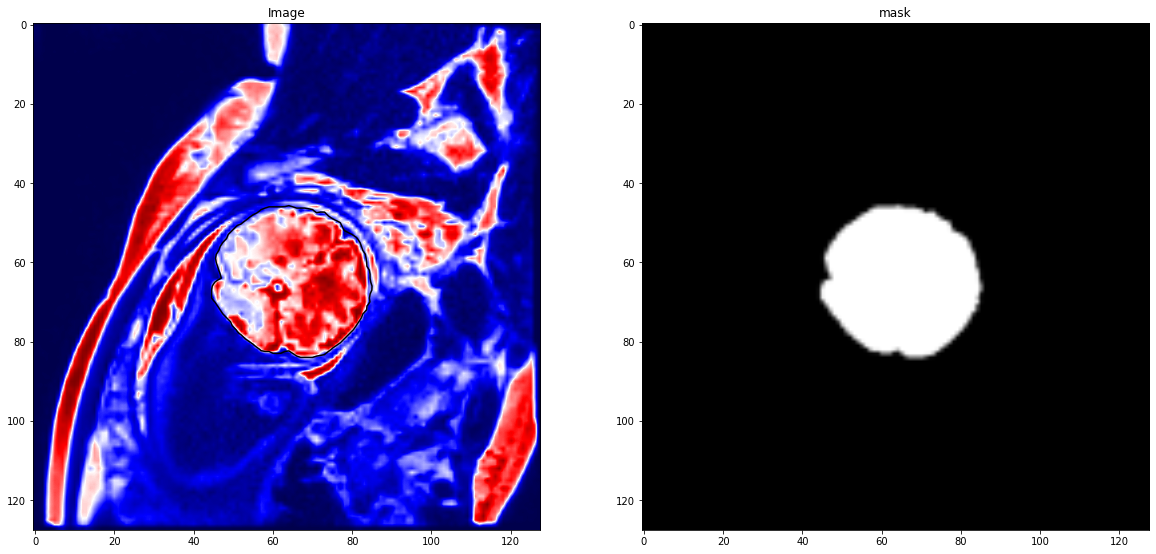

In [14]:
#random sample of training data image and mask
ix = random.randint(12, len(X_train))
has_mask = Y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(Y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Image')
ax[1].imshow(Y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('mask');

# L'Histogramme

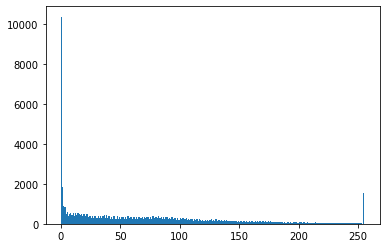

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('fetus_0408.png',0)
plt.hist(img.ravel(),256,[0,256]); plt.show()

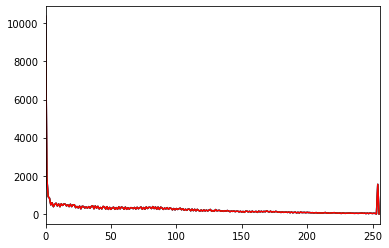

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('fetus_0408.png')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

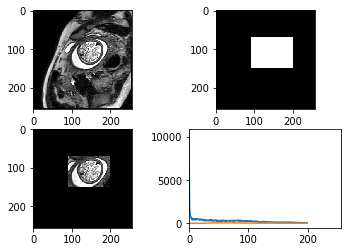

In [27]:
img = cv2.imread('fetus_0408.png',0)

# create a mask
mask = np.zeros(img.shape[:2], np.uint8)
mask[70:150, 90:200] = 255
masked_img = cv2.bitwise_and(img,img,mask = mask)

# Calculate histogram with mask and without mask
# Check third argument for mask
hist_full = cv2.calcHist([img],[0],None,[200],[0,200])
hist_mask = cv2.calcHist([img],[0],mask,[200],[0,200])

plt.subplot(221), plt.imshow(img, 'gray')
plt.subplot(222), plt.imshow(mask,'gray')
plt.subplot(223), plt.imshow(masked_img, 'gray')
plt.subplot(224), plt.plot(hist_full), plt.plot(hist_mask)
plt.xlim([0,256])

plt.show()

In [9]:
#Valeur moyenne des pixels

from PIL import Image
im = Image.open('fetus_0408.png')
im_grey = im.convert('LA')
width, height = im.size

total = 0
for i in range(0, width):
    for j in range(0, height):
        total += im_grey.getpixel((i,j))[0]

mean = total / (width * height)
print(mean)

68.77487182617188


In [11]:
image = io.imread('fetus_0408.png')
image = img_as_float(image)
print(np.mean(image))

0.2697053797104779


# Augmentation du contraste

In [ ]:
import cv2
from pylab import array, plot, show, axis, arange, figure, uint8 

# Image data
image = cv2.imread('fetus_0408.png',0) 
cv2.imshow('image',image)
maxIntensity = 255.0 
x = arange(maxIntensity) 

# Parameters for manipulating image data
phi = 1
theta = 1

# Increase intensity such that
# dark pixels become much brighter, 
# bright pixels become slightly bright
newImage0 = (maxIntensity/phi)*(image/(maxIntensity/theta))**0.5
newImage0 = array(newImage0,dtype=uint8)

cv2.imshow('newImage0',newImage0)
cv2.imwrite('newImage0.jpg',newImage0)

y = (maxIntensity/phi)*(x/(maxIntensity/theta))**0.5
# Decrease intensity such that
# dark pixels become much darker, 
# bright pixels become slightly dark 
newImage1 = (maxIntensity/phi)*(image/(maxIntensity/theta))**2
newImage1 = array(newImage1,dtype=uint8)

cv2.imshow('newImage1',newImage1)

z = (maxIntensity/phi)*(x/(maxIntensity/theta))**2

figure()
plot(x,y,'r-') # Increased brightness
plot(x,x,'k:') # Original image
plot(x,z, 'b-') # Decreased brightness
#axis('off')
axis('tight')
show()
 
# Opens a window to show the results
closeWindow = -1
while closeWindow<0:
    closeWindow = cv2.waitKey(1) 
cv2.destroyAllWindows()

###  2) image Augmentation
data augmentation is a way to multiply your training data. This is especially important if not much data is available.

In [31]:
                           #----------Create training Generators-----------
# Image and mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')


# fitting mask and image 
image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


In [ ]:
                              #----------Create validation Generators-----------

# Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()


# fitting mask and image 
image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

In [ ]:
# the training and validation generators
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

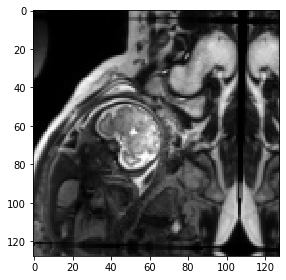

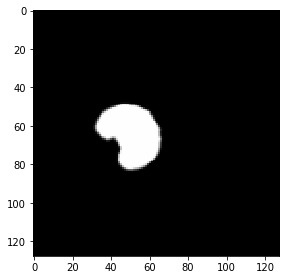

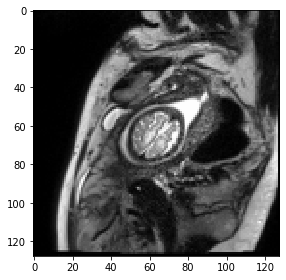

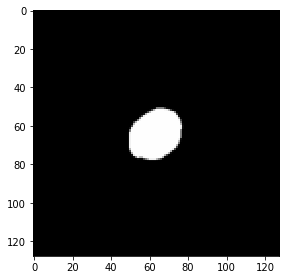

In [32]:
# examining  the shape of the images

imshow(x.next()[0].squeeze())
plt.show()
imshow(np.squeeze(y.next()[0].squeeze()))
plt.show()
imshow(x_val.next()[0].squeeze())
plt.show()
imshow(np.squeeze(y_val.next()[0].squeeze()))
plt.show()

###  3)  the U-net model
After preparing the data and creating both train validation generators, we move now to the next step (building the model).
we chose to work with The U-Net  a deep learning model which is convolutional network architecture for fast and precise segmentation of images, U-Net can be trained end-to-end with fewer training samples.

In [34]:
# Intersection over Union metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [35]:
# Dice coefficient metric
def dice_coef(y_true, y_pred):
 
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [36]:
# plot training and validation data of model
def plot_model_history(history):
    
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('model dice coefficient')
    plt.ylabel('dice_coefficient')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for mean iou
    plt.plot(history.history['mean_iou'])
    plt.plot(history.history['val_mean_iou'])
    plt.title('model mean_iou ')
    plt.ylabel('mean_iou')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


In [37]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou ,dice_coef,'accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 128, 128, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 160         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 128, 128, 16) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

###  4. Training

In [38]:

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint('best-model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]
# Fitting the model
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=200,
                              epochs=10, callbacks=callbacks)


Epoch 1/10
 97/200 [=============>................] - ETA: 43:18 - loss: 0.6934 - mean_iou: 0.0000e+00 - dice_coef: 0.1051 - accuracy: 0.46 - ETA: 31:02 - loss: 0.6690 - mean_iou: 0.4123 - dice_coef: 0.0965 - accuracy: 0.5875   - ETA: 27:33 - loss: 0.6088 - mean_iou: 0.5349 - dice_coef: 0.0875 - accuracy: 0.65 - ETA: 25:57 - loss: 0.5507 - mean_iou: 0.5338 - dice_coef: 0.0889 - accuracy: 0.70 - ETA: 25:03 - loss: 0.4868 - mean_iou: 0.5238 - dice_coef: 0.0808 - accuracy: 0.75 - ETA: 24:14 - loss: 0.4443 - mean_iou: 0.5176 - dice_coef: 0.0733 - accuracy: 0.78 - ETA: 23:30 - loss: 0.4198 - mean_iou: 0.5135 - dice_coef: 0.0672 - accuracy: 0.80 - ETA: 22:51 - loss: 0.3875 - mean_iou: 0.5106 - dice_coef: 0.0642 - accuracy: 0.82 - ETA: 22:14 - loss: 0.6804 - mean_iou: 0.5085 - dice_coef: 0.0653 - accuracy: 0.74 - ETA: 21:30 - loss: 0.6347 - mean_iou: 0.5027 - dice_coef: 0.0624 - accuracy: 0.76 - ETA: 20:54 - loss: 0.5956 - mean_iou: 0.4983 - dice_coef: 0.0607 - accuracy: 0.77 - ETA: 20:31 - 

 98/200 [=============>................] - ETA: 17:24 - loss: 0.0524 - mean_iou: 0.4909 - dice_coef: 0.6414 - accuracy: 0.93 - ETA: 16:51 - loss: 0.0567 - mean_iou: 0.4909 - dice_coef: 0.6696 - accuracy: 0.92 - ETA: 16:41 - loss: 0.0584 - mean_iou: 0.4909 - dice_coef: 0.6379 - accuracy: 0.92 - ETA: 17:56 - loss: 0.0581 - mean_iou: 0.4909 - dice_coef: 0.6268 - accuracy: 0.93 - ETA: 19:28 - loss: 0.0579 - mean_iou: 0.4908 - dice_coef: 0.6459 - accuracy: 0.92 - ETA: 19:40 - loss: 0.0575 - mean_iou: 0.4908 - dice_coef: 0.6317 - accuracy: 0.93 - ETA: 19:22 - loss: 0.0570 - mean_iou: 0.4908 - dice_coef: 0.6430 - accuracy: 0.92 - ETA: 19:18 - loss: 0.0562 - mean_iou: 0.4908 - dice_coef: 0.6480 - accuracy: 0.92 - ETA: 18:32 - loss: 0.0564 - mean_iou: 0.4908 - dice_coef: 0.6493 - accuracy: 0.93 - ETA: 18:20 - loss: 0.0563 - mean_iou: 0.4908 - dice_coef: 0.6580 - accuracy: 0.92 - ETA: 18:17 - loss: 0.0567 - mean_iou: 0.4908 - dice_coef: 0.6631 - accuracy: 0.92 - ETA: 18:18 - loss: 0.0556 - mean_

200/200 [==============================] - ETA: 15s - loss: 0.0527 - mean_iou: 0.4888 - dice_coef: 0.7029 - accuracy: 0.93 - ETA: 10s - loss: 0.0526 - mean_iou: 0.4888 - dice_coef: 0.7035 - accuracy: 0.93 - ETA: 5s - loss: 0.0526 - mean_iou: 0.4888 - dice_coef: 0.7030 - accuracy: 0.9301 - 1069s 5s/step - loss: 0.0525 - mean_iou: 0.4888 - dice_coef: 0.7036 - accuracy: 0.9301 - val_loss: 0.0369 - val_mean_iou: 0.4869 - val_dice_coef: 0.8164 - val_accuracy: 0.9241

Epoch 00002: val_loss improved from 0.05873 to 0.03693, saving model to best-model.h5
Epoch 3/10
 98/200 [=============>................] - ETA: 18:07 - loss: 0.0411 - mean_iou: 0.4867 - dice_coef: 0.7968 - accuracy: 0.92 - ETA: 17:39 - loss: 0.0379 - mean_iou: 0.4867 - dice_coef: 0.8039 - accuracy: 0.92 - ETA: 17:07 - loss: 0.0372 - mean_iou: 0.4867 - dice_coef: 0.8105 - accuracy: 0.92 - ETA: 16:50 - loss: 0.0375 - mean_iou: 0.4867 - dice_coef: 0.8061 - accuracy: 0.92 - ETA: 17:02 - loss: 0.0368 - mean_iou: 0.4867 - dice_coef:

 98/200 [=============>................] - ETA: 16:31 - loss: 0.0258 - mean_iou: 0.4844 - dice_coef: 0.8206 - accuracy: 0.94 - ETA: 16:20 - loss: 0.0263 - mean_iou: 0.4844 - dice_coef: 0.8336 - accuracy: 0.94 - ETA: 16:18 - loss: 0.0316 - mean_iou: 0.4844 - dice_coef: 0.8390 - accuracy: 0.93 - ETA: 16:13 - loss: 0.0304 - mean_iou: 0.4844 - dice_coef: 0.8492 - accuracy: 0.92 - ETA: 16:10 - loss: 0.0322 - mean_iou: 0.4843 - dice_coef: 0.8469 - accuracy: 0.92 - ETA: 16:03 - loss: 0.0304 - mean_iou: 0.4843 - dice_coef: 0.8462 - accuracy: 0.93 - ETA: 15:59 - loss: 0.0303 - mean_iou: 0.4843 - dice_coef: 0.8463 - accuracy: 0.93 - ETA: 15:55 - loss: 0.0297 - mean_iou: 0.4843 - dice_coef: 0.8487 - accuracy: 0.93 - ETA: 15:52 - loss: 0.0285 - mean_iou: 0.4843 - dice_coef: 0.8496 - accuracy: 0.93 - ETA: 15:48 - loss: 0.0284 - mean_iou: 0.4843 - dice_coef: 0.8519 - accuracy: 0.93 - ETA: 15:43 - loss: 0.0282 - mean_iou: 0.4843 - dice_coef: 0.8559 - accuracy: 0.92 - ETA: 15:38 - loss: 0.0283 - mean_

200/200 [==============================] - ETA: 14s - loss: 0.0258 - mean_iou: 0.4837 - dice_coef: 0.8567 - accuracy: 0.93 - ETA: 9s - loss: 0.0258 - mean_iou: 0.4837 - dice_coef: 0.8567 - accuracy: 0.9340 - ETA: 4s - loss: 0.0257 - mean_iou: 0.4836 - dice_coef: 0.8569 - accuracy: 0.934 - 1007s 5s/step - loss: 0.0258 - mean_iou: 0.4836 - dice_coef: 0.8567 - accuracy: 0.9339 - val_loss: 0.0218 - val_mean_iou: 0.4829 - val_dice_coef: 0.8983 - val_accuracy: 0.9233

Epoch 00004: val_loss improved from 0.02362 to 0.02183, saving model to best-model.h5
Epoch 5/10
 98/200 [=============>................] - ETA: 16:18 - loss: 0.0306 - mean_iou: 0.4829 - dice_coef: 0.8268 - accuracy: 0.94 - ETA: 16:41 - loss: 0.0278 - mean_iou: 0.4829 - dice_coef: 0.8402 - accuracy: 0.94 - ETA: 16:30 - loss: 0.0258 - mean_iou: 0.4829 - dice_coef: 0.8537 - accuracy: 0.93 - ETA: 15:13 - loss: 0.0249 - mean_iou: 0.4829 - dice_coef: 0.8427 - accuracy: 0.93 - ETA: 15:21 - loss: 0.0237 - mean_iou: 0.4829 - dice_coef:

 98/200 [=============>................] - ETA: 16:22 - loss: 0.0204 - mean_iou: 0.4819 - dice_coef: 0.8827 - accuracy: 0.94 - ETA: 16:13 - loss: 0.0205 - mean_iou: 0.4819 - dice_coef: 0.8726 - accuracy: 0.94 - ETA: 16:10 - loss: 0.0258 - mean_iou: 0.4819 - dice_coef: 0.8644 - accuracy: 0.93 - ETA: 16:06 - loss: 0.0252 - mean_iou: 0.4819 - dice_coef: 0.8677 - accuracy: 0.93 - ETA: 16:02 - loss: 0.0236 - mean_iou: 0.4819 - dice_coef: 0.8745 - accuracy: 0.93 - ETA: 15:57 - loss: 0.0243 - mean_iou: 0.4819 - dice_coef: 0.8733 - accuracy: 0.93 - ETA: 15:54 - loss: 0.0248 - mean_iou: 0.4819 - dice_coef: 0.8700 - accuracy: 0.93 - ETA: 15:49 - loss: 0.0248 - mean_iou: 0.4819 - dice_coef: 0.8642 - accuracy: 0.93 - ETA: 15:44 - loss: 0.0241 - mean_iou: 0.4819 - dice_coef: 0.8645 - accuracy: 0.93 - ETA: 15:39 - loss: 0.0235 - mean_iou: 0.4819 - dice_coef: 0.8659 - accuracy: 0.93 - ETA: 15:35 - loss: 0.0233 - mean_iou: 0.4819 - dice_coef: 0.8687 - accuracy: 0.93 - ETA: 15:31 - loss: 0.0235 - mean_

200/200 [==============================] - ETA: 15s - loss: 0.0214 - mean_iou: 0.4816 - dice_coef: 0.8802 - accuracy: 0.93 - ETA: 10s - loss: 0.0214 - mean_iou: 0.4816 - dice_coef: 0.8803 - accuracy: 0.93 - ETA: 5s - loss: 0.0214 - mean_iou: 0.4816 - dice_coef: 0.8803 - accuracy: 0.9337 - 1014s 5s/step - loss: 0.0214 - mean_iou: 0.4816 - dice_coef: 0.8805 - accuracy: 0.9336 - val_loss: 0.0160 - val_mean_iou: 0.4813 - val_dice_coef: 0.9214 - val_accuracy: 0.9244

Epoch 00006: val_loss improved from 0.02183 to 0.01605, saving model to best-model.h5
Epoch 7/10
 98/200 [=============>................] - ETA: 15:50 - loss: 0.0126 - mean_iou: 0.4812 - dice_coef: 0.9255 - accuracy: 0.93 - ETA: 16:06 - loss: 0.0141 - mean_iou: 0.4812 - dice_coef: 0.9178 - accuracy: 0.93 - ETA: 16:05 - loss: 0.0148 - mean_iou: 0.4812 - dice_coef: 0.9182 - accuracy: 0.93 - ETA: 16:03 - loss: 0.0151 - mean_iou: 0.4812 - dice_coef: 0.9135 - accuracy: 0.93 - ETA: 16:00 - loss: 0.0159 - mean_iou: 0.4812 - dice_coef:

 98/200 [=============>................] - ETA: 16:05 - loss: 0.0222 - mean_iou: 0.4807 - dice_coef: 0.8699 - accuracy: 0.93 - ETA: 16:10 - loss: 0.0225 - mean_iou: 0.4807 - dice_coef: 0.8822 - accuracy: 0.92 - ETA: 16:07 - loss: 0.0213 - mean_iou: 0.4807 - dice_coef: 0.8891 - accuracy: 0.92 - ETA: 16:04 - loss: 0.0202 - mean_iou: 0.4807 - dice_coef: 0.8931 - accuracy: 0.92 - ETA: 15:58 - loss: 0.0198 - mean_iou: 0.4807 - dice_coef: 0.8927 - accuracy: 0.92 - ETA: 15:57 - loss: 0.0197 - mean_iou: 0.4807 - dice_coef: 0.8920 - accuracy: 0.92 - ETA: 15:54 - loss: 0.0193 - mean_iou: 0.4807 - dice_coef: 0.8937 - accuracy: 0.92 - ETA: 15:48 - loss: 0.0203 - mean_iou: 0.4807 - dice_coef: 0.8944 - accuracy: 0.92 - ETA: 15:44 - loss: 0.0206 - mean_iou: 0.4807 - dice_coef: 0.8934 - accuracy: 0.92 - ETA: 15:39 - loss: 0.0203 - mean_iou: 0.4807 - dice_coef: 0.8961 - accuracy: 0.92 - ETA: 15:34 - loss: 0.0198 - mean_iou: 0.4807 - dice_coef: 0.8964 - accuracy: 0.92 - ETA: 15:30 - loss: 0.0203 - mean_

200/200 [==============================] - ETA: 14s - loss: 0.0191 - mean_iou: 0.4805 - dice_coef: 0.8918 - accuracy: 0.93 - ETA: 9s - loss: 0.0190 - mean_iou: 0.4805 - dice_coef: 0.8919 - accuracy: 0.9343 - ETA: 4s - loss: 0.0190 - mean_iou: 0.4805 - dice_coef: 0.8920 - accuracy: 0.934 - 1001s 5s/step - loss: 0.0190 - mean_iou: 0.4805 - dice_coef: 0.8922 - accuracy: 0.9343 - val_loss: 0.0224 - val_mean_iou: 0.4803 - val_dice_coef: 0.9115 - val_accuracy: 0.9287

Epoch 00008: val_loss did not improve from 0.01605
Epoch 9/10
 98/200 [=============>................] - ETA: 16:16 - loss: 0.0159 - mean_iou: 0.4803 - dice_coef: 0.9209 - accuracy: 0.92 - ETA: 16:15 - loss: 0.0135 - mean_iou: 0.4803 - dice_coef: 0.9156 - accuracy: 0.93 - ETA: 16:11 - loss: 0.0150 - mean_iou: 0.4803 - dice_coef: 0.9195 - accuracy: 0.92 - ETA: 16:05 - loss: 0.0163 - mean_iou: 0.4803 - dice_coef: 0.9152 - accuracy: 0.92 - ETA: 16:01 - loss: 0.0156 - mean_iou: 0.4803 - dice_coef: 0.9155 - accuracy: 0.93 - ETA: 15:

 98/200 [=============>................] - ETA: 16:24 - loss: 0.0115 - mean_iou: 0.4800 - dice_coef: 0.9123 - accuracy: 0.94 - ETA: 16:28 - loss: 0.0117 - mean_iou: 0.4800 - dice_coef: 0.9178 - accuracy: 0.94 - ETA: 16:28 - loss: 0.0119 - mean_iou: 0.4800 - dice_coef: 0.9165 - accuracy: 0.94 - ETA: 16:40 - loss: 0.0124 - mean_iou: 0.4800 - dice_coef: 0.9116 - accuracy: 0.94 - ETA: 16:29 - loss: 0.0135 - mean_iou: 0.4800 - dice_coef: 0.9132 - accuracy: 0.93 - ETA: 16:25 - loss: 0.0136 - mean_iou: 0.4800 - dice_coef: 0.9141 - accuracy: 0.93 - ETA: 16:18 - loss: 0.0148 - mean_iou: 0.4800 - dice_coef: 0.9142 - accuracy: 0.93 - ETA: 16:11 - loss: 0.0143 - mean_iou: 0.4800 - dice_coef: 0.9142 - accuracy: 0.93 - ETA: 16:06 - loss: 0.0147 - mean_iou: 0.4800 - dice_coef: 0.9158 - accuracy: 0.93 - ETA: 16:00 - loss: 0.0156 - mean_iou: 0.4800 - dice_coef: 0.9146 - accuracy: 0.93 - ETA: 15:54 - loss: 0.0159 - mean_iou: 0.4800 - dice_coef: 0.9154 - accuracy: 0.93 - ETA: 15:48 - loss: 0.0158 - mean_

200/200 [==============================] - ETA: 15s - loss: 0.0141 - mean_iou: 0.4798 - dice_coef: 0.9178 - accuracy: 0.93 - ETA: 10s - loss: 0.0141 - mean_iou: 0.4798 - dice_coef: 0.9178 - accuracy: 0.93 - ETA: 5s - loss: 0.0141 - mean_iou: 0.4798 - dice_coef: 0.9176 - accuracy: 0.9346 - 1021s 5s/step - loss: 0.0141 - mean_iou: 0.4798 - dice_coef: 0.9177 - accuracy: 0.9346 - val_loss: 0.0135 - val_mean_iou: 0.4797 - val_dice_coef: 0.9285 - val_accuracy: 0.9248

Epoch 00010: val_loss improved from 0.01605 to 0.01346, saving model to best-model.h5


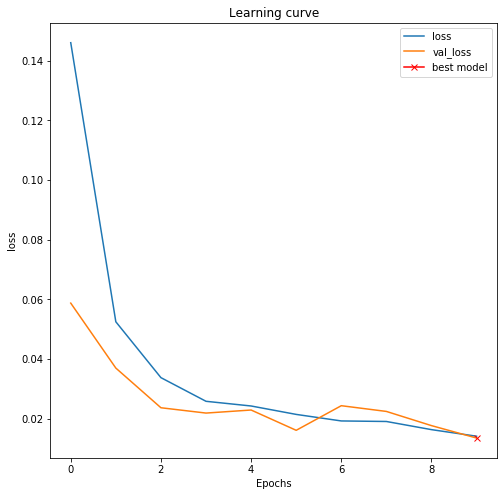

In [49]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

dict_keys(['val_loss', 'val_mean_iou', 'val_dice_coef', 'val_accuracy', 'loss', 'mean_iou', 'dice_coef', 'accuracy', 'lr'])


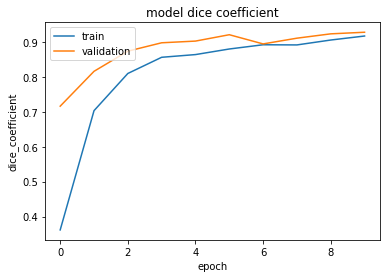

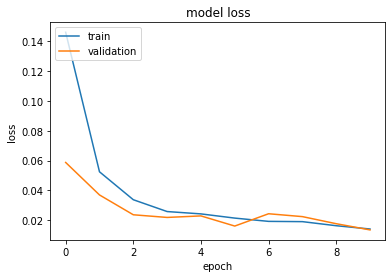

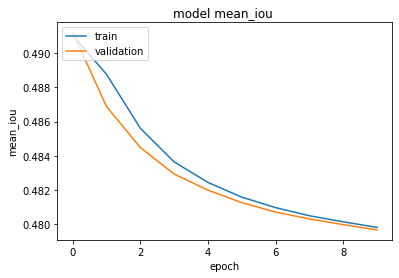

In [40]:
# checking the metrics
plot_model_history(results)

###  5) Loading the pre-trained model-Prediction

In [41]:
model.load_weights('best-model.h5')

In [135]:
# Predict on train, val and test
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_test = model.predict(X_test, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


360/360 [==============================] - ETA: 44 - ETA: 39 - ETA: 37 - ETA: 34 - ETA: 29 - ETA: 26 - ETA: 21 - ETA: 16 - ETA: 11 - ETA: 6 - ETA:  - 59s 164ms/step


In [3]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='b', levels=[0.5])
    ax[2].set_title('predected mask')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='w', levels=[0.5])
    ax[3].set_title(' Predicted binary mask');
    


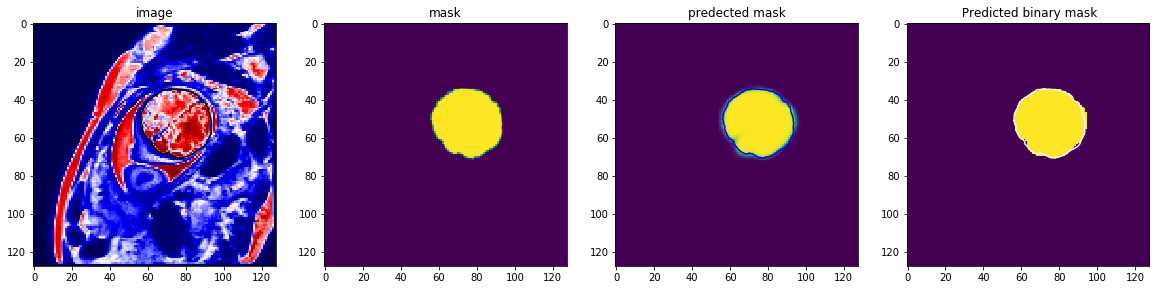

In [122]:
plot_sample(X_train, Y_train, preds_train, preds_train_t, ix=14)


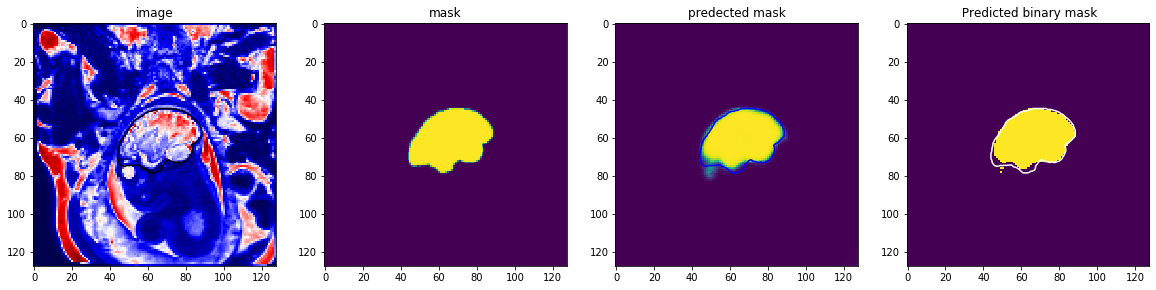

In [123]:
# check on some random training samples
a=random.randint(7, len(preds_train_t))                 
plot_sample(X_train,Y_train, preds_train, preds_train_t, ix=a)


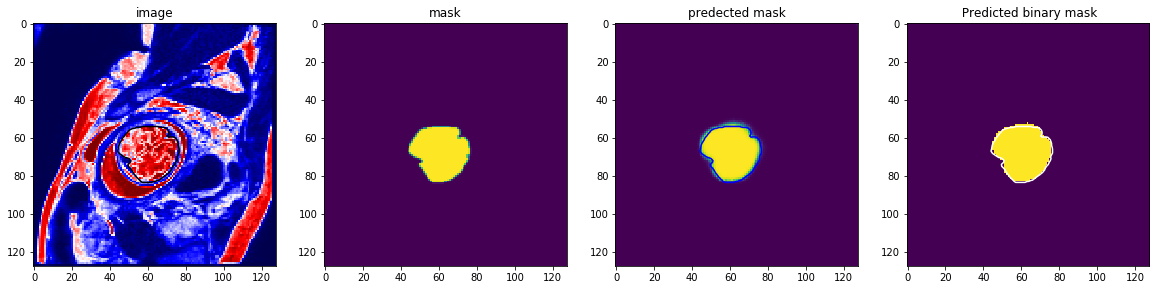

In [138]:
# check on some random validation samples
a=random.randint(0, len(preds_val_t))                 
plot_sample(X_train,Y_train, preds_val, preds_val_t, ix=a)

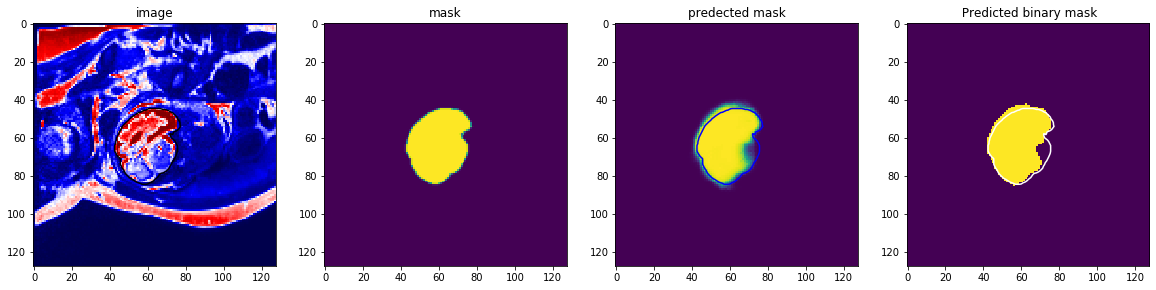

In [145]:
# check on some random test samples
a=random.randint(7, len(preds_test_t))  
plot_sample(X_test, Y_test, preds_test, preds_test_t, ix=a)

